# Multi-Objective Genetic Algorithm
Verification based on Wang 2016.

In [ ]:
"""
    This file is subject to the terms and conditions defined in
    file 'LICENSE.txt', which is part of this source code package.
    © 2020, CAMY Labotech

    Engineer : Cahya Amalinadhi Putra
"""

## Preparation

### Import Library

In [14]:
# Import Library
import copy
import matplotlib.pyplot as plt
import math
import numpy as np
import operator
import pandas as pd
import random

In [3]:
# Connect GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
# Set path
path = '/content/drive/My Drive/Eksternal CL/Consultation/DSE/01 - Optimizing Welding Time/Codes/MOGA Verification'

### Execute Class

In [18]:
class MOGA:

    def __init__(self, fname):
        self.filePath = path + '/' + fname
        self.readData()

    def readData(self):
        #filePath = path + '/routes.csv'

        # Read file
        self.df = pd.read_csv(self.filePath)
        self.points = np.array([i+1 for i in range(len(self.df['X']))])

    def optimize(self, generations, popSize, eliteSize, mutationRate, crossoverRate):
        # Initialization
        self.generations = generations
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        self.crossoverRate = crossoverRate

        #
        self.genHist = []
        self.disHist = []

        # 1.1 Generate initial population of size-n
        self.initializePopulation()

        # ==================
        for gen in range(self.generations):
            # 1.2 Sort members in ascending order according to their path lengths
            self.rankRoutes()
            # print(self.fitnessResults)

            # 2. Save q-elitist members with best ranking among n-parents
            self.elitist()
            # print(self.elitistMember)

            # 3. Using crossover operator, generate 2n-offsprings
            self.selection()
            # print(self.selectionResults)

            self.matingPool()
            # print(self.children)

            # 4. Generate new-population consisting 2n-offsprings and elitist from step 2
            newPopTemp = []
            for child in self.children:
                newPopTemp.append(child)

            self.population = copy.deepcopy(np.array(newPopTemp))

            # 5. Sort the member of 4 in ascending order
            self.rankRoutes()
            # print(self.fitnessResults)

            # 6. Save q-elitist members from step 5
            self.elitist()
            # print(self.elitistMember)

            # 7. Using mutation operator, modify the 2n offsprings generated by crossover
            self.mutate()

            # 8. Regenerate new-population consist: 2npm mutated offspring, 2n(1-pm) unmutated of spring, q elitist from step 6
            newPopTemp = []
            # Add q-elitist
            for q in self.elitistMember:
                newPopTemp.append(q)

            # Add population
            for individual in self.population:
                newPopTemp.append(individual)

            self.population = copy.deepcopy(np.array(newPopTemp))

            # 9. Sort the member according to ascending order
            self.rankRoutes()
            # print(self.fitnessResults)

            # 10. Select n members with the best ranking withing step 9
            newPopTemp = []
            for i in range(self.popSize):
                newPopTemp.append(np.array(self.population[self.fitnessResults[i][0]]))

            self.population = copy.deepcopy(np.array(newPopTemp))

            self.genHist.append(int(gen + 1))
            self.disHist.append(self.fitnessResults[0][1])
            #print(f"The best route distance = {self.fitnessResults[0][1]}")

        self.bestIndividual = np.array(self.population[self.fitnessResults[0][0]])
        self.bestDistance = self.fitnessResults[0][1]

    def initializePopulation(self):
        self.population = []

        for i in range(self.popSize):
            self.population.append(np.random.permutation(self.points))

    def rankRoutes(self):
        # Calculate distances
        self.distanceCalculation(self.population)

        # Rank calculated distances
        fitnessTemp = {}
        for i in range(self.popSize):
            fitnessTemp[i] = float(self.distance[i])

        self.fitnessResults = copy.deepcopy(sorted(fitnessTemp.items(), key=operator.itemgetter(1), reverse=False))

    def elitist(self):
        elitistTemp = []

        for i in range(self.eliteSize):
            # elitistTemp.append(self.fitnessResults[0][0])
            elitistTemp.append(self.population[self.fitnessResults[0][0]])

        self.elitistMember = copy.deepcopy(elitistTemp)

    def selection(self):
        # Selection of parents use Fitness proportionate selection or Roulette wheel selection
        tempSelectionResults = []
        df = pd.DataFrame(np.array(self.fitnessResults), columns=["Index", "Fitness"])
        df["F1"] = [self.crossoverRate * ((1 - self.crossoverRate) ** (i)) for i in
                    range(len(self.population))]  # Solve Eq. (43)
        df["F2"] = [1 - ((i) / len(self.population)) for i in range(len(self.population))]  # Solve Eq. (44)
        df["cumsum1"] = df.F1.cumsum() / df.F1.sum()  # Solve eq. (45) - eq. (47)
        df["cumsum2"] = df.F2.cumsum() / df.F2.sum()  # Solve eq. (45) - eq. (47)

        for i in range(len(self.fitnessResults)):
            rn = random.random()
            # print(f"random number = {rn}")

            # If i is an odd number, use cumsum1. Else, use cumsum2
            # Solve Eq. (48)
            for j in range(len(self.fitnessResults)):
                if (i % 2 == 1):
                    if (rn <= df["cumsum1"][j]):
                        tempSelectionResults.append(self.fitnessResults[j][0])
                        break

                elif (i % 2 == 0):
                    if (rn <= df["cumsum2"][j]):
                        tempSelectionResults.append(self.fitnessResults[j][0])
                        break

        self.selectionResults = copy.deepcopy(tempSelectionResults)

    def matingPool(self):
        tempMatingPop = []

        for i in range(len(self.selectionResults)):
            index = self.selectionResults[i]
            tempMatingPop.append(self.population[index])

        self.matingPop = copy.deepcopy(tempMatingPop)

        tempChildren = []

        for i in range(0, len(self.matingPop), 2):
            father = self.matingPop[i]
            mother = self.matingPop[i + 1]
            child = self.crossover(father, mother)
            for j in child:
                tempChildren.append(j)

        self.children = copy.deepcopy(tempChildren)

    def crossover(self, father, mother):
        # Initialization
        length = len(father)
        child_1 = np.zeros(length)
        child_2 = np.zeros(length)
        child_3 = np.zeros(length)
        child_4 = np.zeros(length)

        # FOR CHILD 1 and 2
        # Generate 2 random values as intersection points
        # Make sure the random number is not similar
        rn1 = random.randint(1, length - 1)
        rn2 = random.randint(1, length - 1)
        if (rn1 == rn2):
            while (rn2 == rn1):
                rn2 = random.randint(1, length - 1)

        # Check and make sure rn1 < rn2
        if (rn1 > rn2):
            temp = rn2
            rn2 = rn1
            rn1 = temp

        # 1. Leave the middle sections between the two intersection points
        # mid_sec = np.arange(rn1, rn2, 1)

        # 2. Rotate the 3rd section to the beginning of the route in each member
        father_temp = np.append(father[rn2:], father[:rn1])
        father_temp = np.append(father_temp, father[rn1:rn2])

        mother_temp = np.append(mother[rn2:], mother[:rn1])
        mother_temp = np.append(mother_temp, mother[rn1:rn2])

        # 3. Delete the elements in mother which are the same as the elements in middle sections of father
        indexToDelete_father = []
        indexToDelete_mother = []
        for i in range(length):
            for j in range(rn1, rn2):
                if (father_temp[i] == mother[j]):
                    indexToDelete_father.append(i)

                if (mother_temp[i] == father[j]):
                    indexToDelete_mother.append(i)

        father_temp = np.delete(father_temp, indexToDelete_father)
        mother_temp = np.delete(mother_temp, indexToDelete_mother)

        # 4. Let k be the number of elements in sec. (3)
        #    Move the first k-elements of the first member obtained in sec. (3) to become
        #    the NEW LAST SECTION of the second member.
        k_1 = len(father[rn2:])
        k_2 = len(mother[rn2:])

        child_1 = np.append(father_temp[k_1:], mother[rn1:rn2])
        child_1 = np.append(child_1, father_temp[:k_1])

        child_2 = np.append(mother_temp[k_2:], father[rn1:rn2])
        child_2 = np.append(child_2, mother_temp[:k_2])

        # FOR CHILD 3 and 4
        # 1. Exchange sec. (1) and sec. (2) from stage (2)
        AA = np.append(father[rn1:rn2], father[:rn1])
        AA = np.append(AA, father[rn2:])

        BB = np.append(mother[rn1:rn2], mother[:rn1])
        BB = np.append(BB, mother[rn2:])

        # 2. Find sec. (3) in element AA, delete the corresponding ones in BB, vice versa.
        indexToDelete_AA = []
        indexToDelete_BB = []
        for i in range(length):
            for j in range(rn2, length):
                if (AA[i] == BB[j]):
                    indexToDelete_AA.append(i)

                if (BB[i] == AA[j]):
                    indexToDelete_BB.append(i)

        AA_temp = np.delete(AA, indexToDelete_AA)
        BB_temp = np.delete(BB, indexToDelete_BB)

        # 3. Make sec. (3) elements in AA the sec. (3) elements of BB, vice versa.
        child_3 = np.append(AA_temp, BB[rn2:])
        child_4 = np.append(BB_temp, AA[rn2:])

        return ([child_1, child_2, child_3, child_4])

    def mutate(self):
        for individual in self.population:
            # Generate random number
            delta = random.random()

            # if delta <= mutation rate, perform mutation on this individual
            if (delta <= self.mutationRate):
                length = len(individual)

                # 1. Two mutation points are chosen by using a uniform random number generator
                # Make sure the random number is not similar
                rn1 = random.randint(1, length - 1)
                rn2 = random.randint(1, length - 1)

                if (rn1 == rn2):
                    while (rn2 == rn1):
                        rn2 = random.randint(1, length - 1)

                # Check and make sure rn1 < rn2
                if (rn1 > rn2):
                    temp = rn2
                    rn2 = rn1
                    rn1 = rn2

                # 2. The middle section is reversed
                mutated_individual = individual
                mutated_individual[rn1:rn2] = individual[rn1:rn2][::-1]

                individual = copy.deepcopy(mutated_individual)

    def distanceCalculation(self, population):
        self.distance = []

        for route in population:
            tempDist = 0
            for i in range(len(route)):
                if (i>len(route)-2):
                    xDist = (self.df['X'][route[-1]-1] - self.df['X'][route[0]-1])**2
                    yDist = (self.df['Y'][route[-1]-1] - self.df['Y'][route[0]-1])**2

                    tempDist = tempDist + math.sqrt(xDist + yDist)
                else:
                    xDist = (self.df['X'][route[i]-1] - self.df['X'][route[i+1]-1])**2
                    yDist = (self.df['Y'][route[i]-1] - self.df['Y'][route[i+1]-1])**2

                    tempDist = tempDist + math.sqrt(xDist + yDist)

            self.distance.append(tempDist)

        self.distance = copy.deepcopy(np.array(self.distance))

    def postProcessing(self, xlim, ylim):
        # Optimized Data
        print(f'Optimized route      : {self.bestIndividual}')
        print(f'Optimized distance   : {round(self.bestDistance,3)}')

        # Visualization
        fig = plt.figure(figsize=(10, 9))
        ax = plt.subplot(211)

        ax.scatter(self.df['X'], self.df['Y'], c='r', marker='o', s=20)
        for i in range(len(self.df['X'])):
            ax.annotate(i+1, (self.df['X'][i], self.df['Y'][i]))

        for i in range(len(self.df['X'])):
            if (i>len(self.df['X'])-2):
                p = self.bestIndividual[-1]
                np = self.bestIndividual[0]
            else:
                p = self.bestIndividual[i]
                np = self.bestIndividual[i+1]

            ax.plot([self.df['X'][p-1], self.df['X'][np-1]],
                    [self.df['Y'][p-1], self.df['Y'][np-1]], c='b')

        ax.grid(b=True, which='major', color='0.65', linestyle='-')
        ax.grid(b=True, which='minor', color='0.65', linestyle='--')
        ax.set_xlim([0, xlim])
        ax.set_ylim([0, ylim])

        ax2 = plt.subplot(212)
        ax2.plot(self.genHist, self.disHist, c='r')
        ax2.grid(b=True, which='major', color='0.65', linestyle='-')
        ax2.grid(b=True, which='minor', color='0.65', linestyle='--')
        ax2.set_xlim([1, self.generations])
        ax2.set_xlabel('Generations')
        ax2.set_ylabel('Distance')

        plt.show()


## Executes

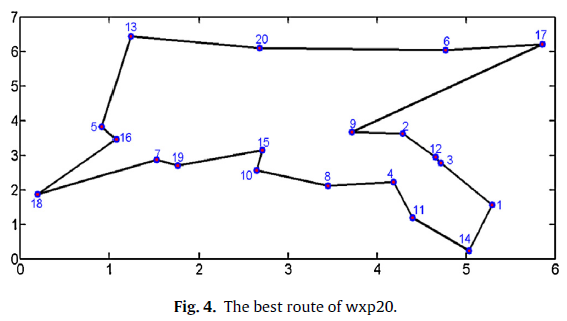

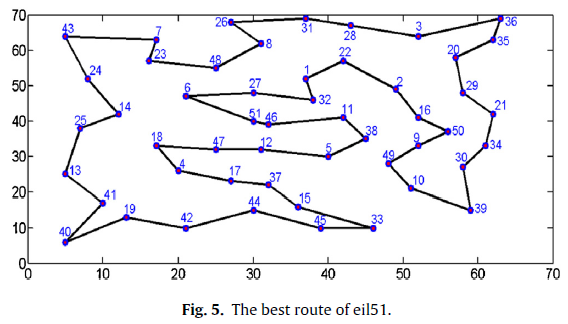

Optimizing 20 Routes
Optimized route      : [10 15 19  7 18 16  5 13 20  6 17  9  2 12  3  1 14 11  4  8]
Optimized distance   : 24.529


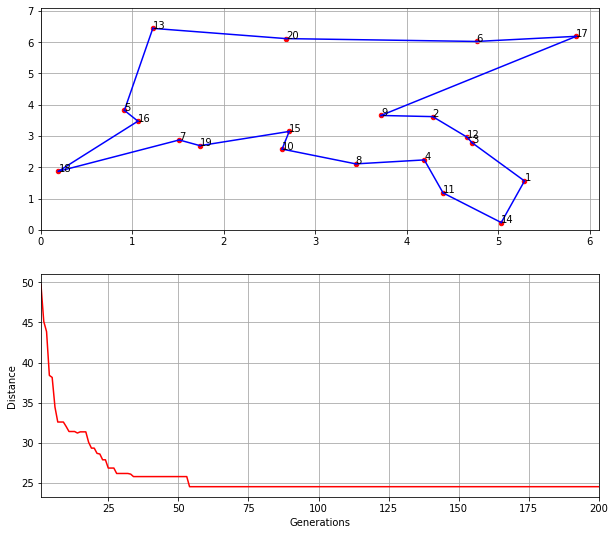

Optimizing 51 Routes
Optimized route      : [14  6 47 17 37 12 46 51 27  8 48  7 43 24 23 26 31 28  3 36 35 20 22  1
 32  2 21 29 16 50  9 34 30 38 11  5 49 10 39 33 45 15 44 42 19 41 40 13
  4 18 25]
Optimized distance   : 488.729


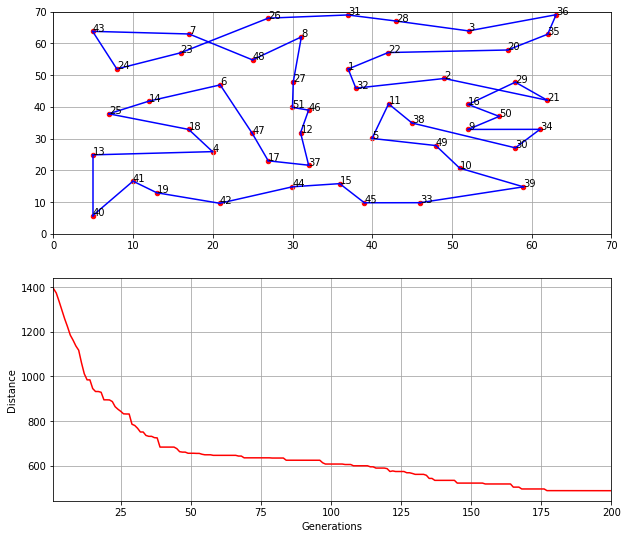

In [22]:
# Input Parameters
popSize = 70                # Number of population per generation
eliteSize = 2               # Number of elitist
mutationRate = 0.275        # Rate of mutation
crossoverRate = 0.295       # Rate of crossover
generations = 200           # Max. number of generations


# Execute
# This command will execute verification based on wxp20 route from wang-2016
# 20 Routes
print('Optimizing 20 Routes')
xlim = 6.1
ylim = 7.1
filename = 'wxp20.csv'

mainProgram = MOGA(filename)
mainProgram.optimize(generations, popSize, eliteSize, mutationRate, crossoverRate)

mainProgram.postProcessing(xlim, ylim)    # display the post processing

# 51 Routes
print('Optimizing 51 Routes')
xlim = 70
ylim = 70
filename = 'eil51.csv'

mainProgram = MOGA(filename)
mainProgram.optimize(generations, popSize, eliteSize, mutationRate, crossoverRate)

mainProgram.postProcessing(xlim, ylim)    # display the post processing